In [335]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from fancyimpute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [336]:
# Load the data
data = pd.read_csv('payment-practicesold.csv')

In [337]:
# Drop columns that are not useful for the model
columns_to_drop = ['Report Id','Start date', 'End date', 'Filing date', 'Company', 'Company number','URL']
data = data.drop(columns=columns_to_drop)

In [338]:
# assigning types of features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object','bool']).columns
missing_data_cols = [i for i in categorical_features if data[i].isnull().sum() > 0]
non_missing_cat = [i for i in categorical_features if i not in missing_data_cols]

In [339]:
# Missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,10381,42.852425
Average time to pay,2448,10.105263
% Invoices paid within 30 days,2448,10.105263
% Invoices paid between 31 and 60 days,2448,10.105263
% Invoices paid later than 60 days,2448,10.105263
% Invoices not paid within agreed terms,2405,9.927761
Shortest (or only) standard payment period,2405,9.927761
Longest standard payment period,9919,40.945304
Maximum contractual payment period,2405,9.927761
Payment terms have changed,2405,9.927761


Handling missing data

In [340]:
data = data.dropna(subset=['E-Invoicing offered'])

In [341]:
data['Payments made in the reporting period'].fillna(0, inplace=True)

In [342]:
for col in numerical_features:
    data[col] = data[col].fillna(data[col].mean())

In [343]:
mice_imputer = IterativeImputer()
data_imputed = mice_imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=data.columns)
data = data_imputed

In [344]:
#missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,0,0.0
Average time to pay,0,0.0
% Invoices paid within 30 days,0,0.0
% Invoices paid between 31 and 60 days,0,0.0
% Invoices paid later than 60 days,0,0.0
% Invoices not paid within agreed terms,0,0.0
Shortest (or only) standard payment period,0,0.0
Longest standard payment period,0,0.0
Maximum contractual payment period,0,0.0
Payment terms have changed,0,0.0


EDA

80th Quantile =  51.0


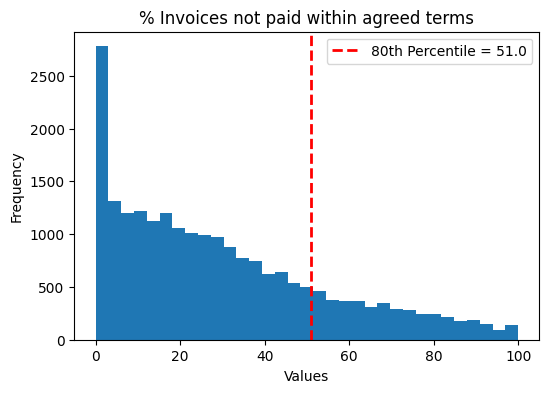

In [345]:
# Bar plot for '% Invoices not paid within agreed terms' and 80th percentile
percentile_80 = np.percentile(data['% Invoices not paid within agreed terms'].dropna(), 80)
print('80th Quantile = ',percentile_80)

plt.hist(data['% Invoices not paid within agreed terms'],bins=33)
plt.axvline(x=percentile_80, color='red', linestyle='dashed', linewidth=2, label='80th Percentile = '+str(percentile_80))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('% Invoices not paid within agreed terms')

# Show the plot
plt.legend()
plt.show()

In [346]:
# Creating target column 'flag' based on the 80th percentile
data['flag'] = 0
data.loc[data['% Invoices not paid within agreed terms'] > percentile_80, 'flag'] = 1
data.drop(columns=['% Invoices not paid within agreed terms'],inplace=True)

<Axes: >

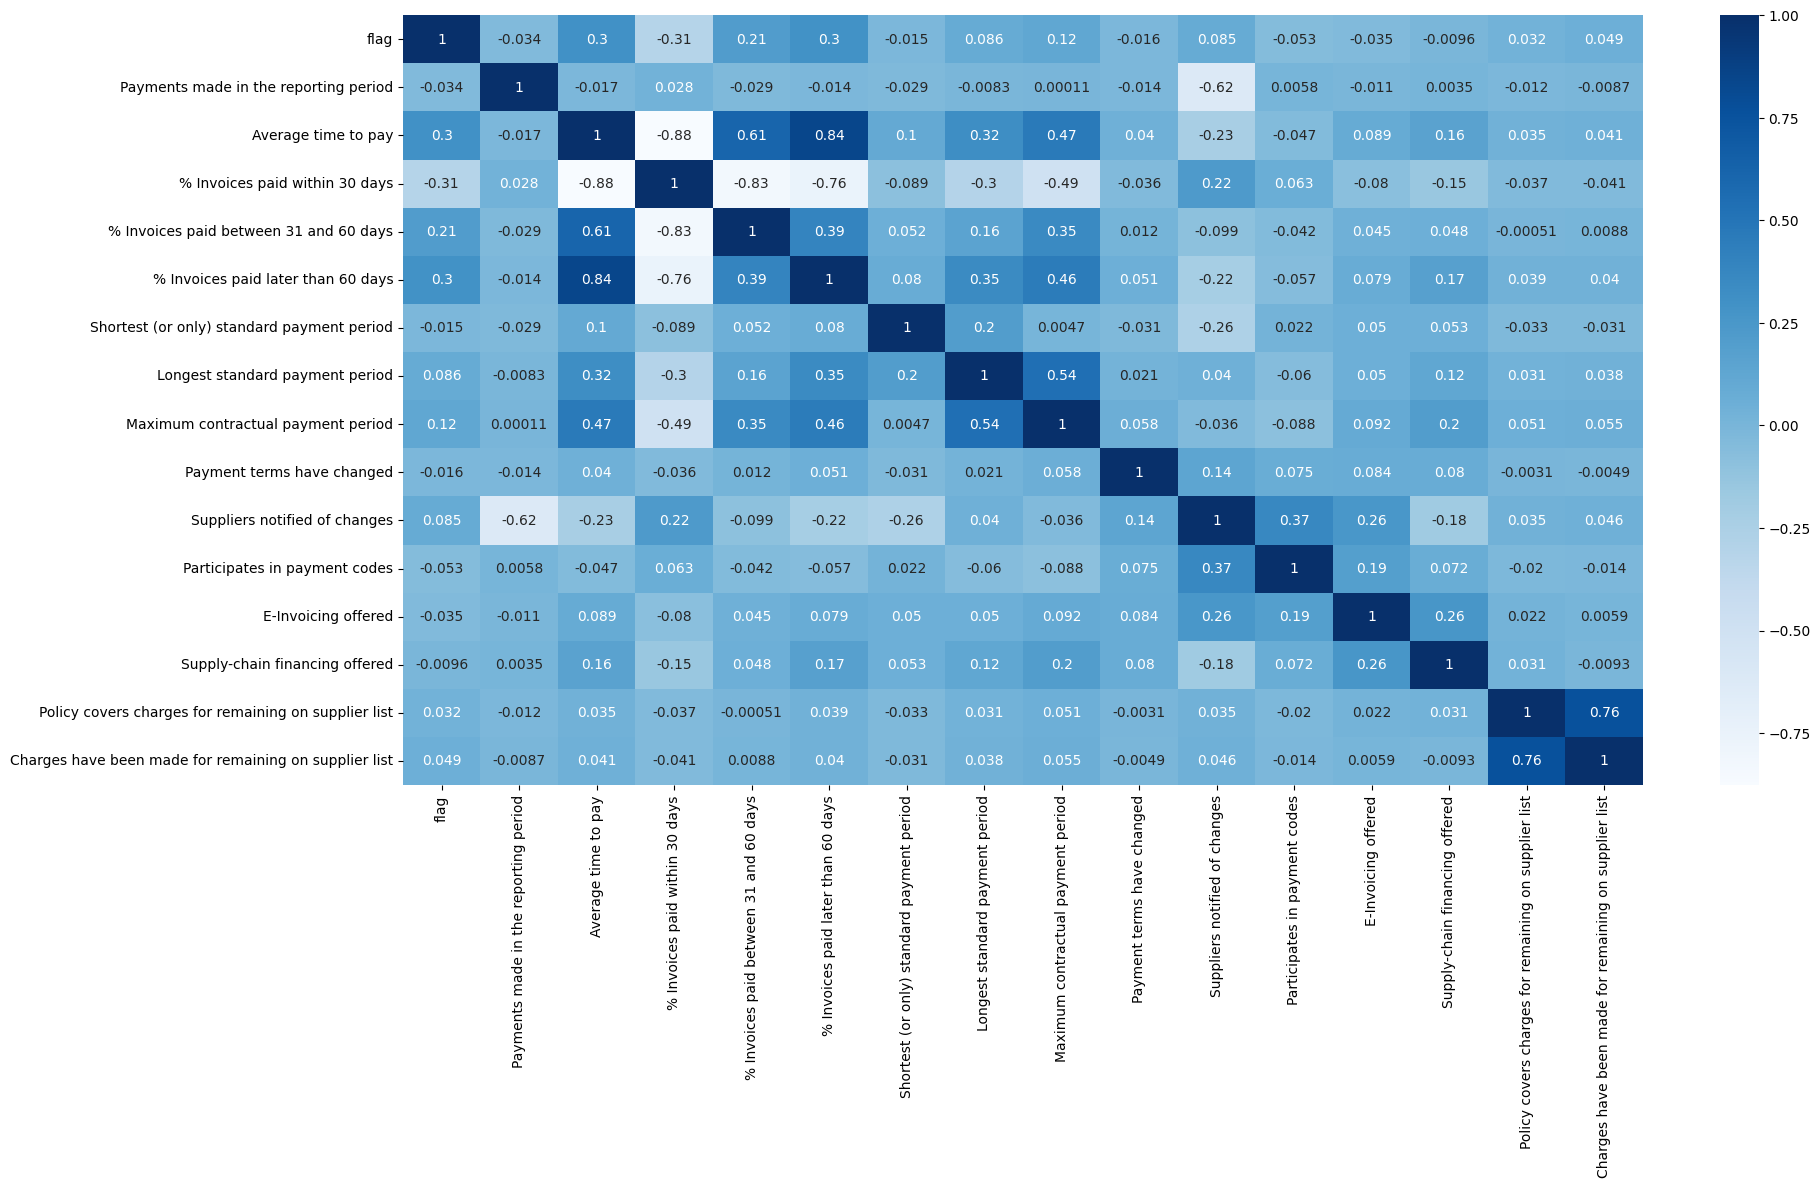

In [347]:
# Correlation Analysis
new_order=[     'flag',
                'Payments made in the reporting period', 'Average time to pay',
                '% Invoices paid within 30 days',
                '% Invoices paid between 31 and 60 days',
                '% Invoices paid later than 60 days',
                'Shortest (or only) standard payment period',
                'Longest standard payment period', 'Maximum contractual payment period',
                'Payment terms have changed', 'Suppliers notified of changes',
                'Participates in payment codes', 'E-Invoicing offered',
                'Supply-chain financing offered',
                'Policy covers charges for remaining on supplier list',
                'Charges have been made for remaining on supplier list']
plt.figure(figsize=(20,10))
sns.heatmap(data.reindex(columns=new_order).corr(method='spearman'),annot=True,cmap='Blues')

In [348]:
# Dropping the Highly correlated Features
data1 = data.drop(columns=[ '% Invoices paid within 30 days', 
                            '% Invoices paid later than 60 days',
                            'Suppliers notified of changes',
                            'Policy covers charges for remaining on supplier list',
                            'Payments made in the reporting period'])

In [349]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(data1.drop(columns=['flag']), data1['flag'], test_size=0.3, random_state=42)

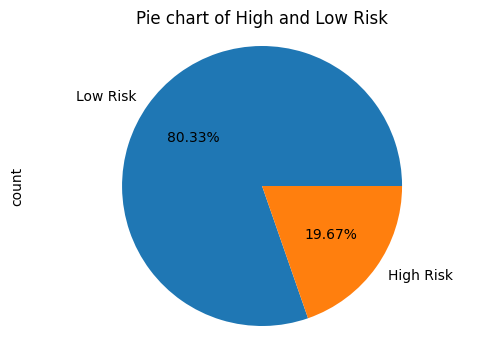

In [350]:
# Pie chart of High and Low Risk before Sampling
y_train.value_counts().plot.pie(autopct='%1.2f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk')
plt.show()

In [351]:
# Implemeting the RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='minority')
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

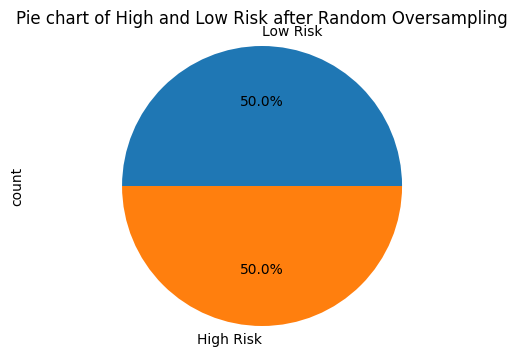

In [352]:
# pie chart of High and Low Risk after Random Oversampling
y_train_oversampled.value_counts().plot.pie(autopct='%1.1f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk after Random Oversampling')
plt.show()

XGBoost

In [353]:
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X_train_oversampled,label=y_train_oversampled)

# XGBoost Model
params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,
    'subsample': 0.85,
    'n_estimators': 900,
} 

xgb_clf = XGBClassifier(**params)

xgb_clf.fit(X_train_oversampled, y_train_oversampled)

y_pred_xgb = xgb_clf.predict(X_test)

# Calculate Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print('XGBoost model accuracy score: ', accuracy_xgb)

# Calculate F1 Score
f1_xgb = f1_score(y_test, y_pred_xgb)
print('F1 Score:', f1_xgb)

# Calculate AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)
print('AUC:', auc_xgb)

XGBoost model accuracy score:  0.7778796211426826
F1 Score: 0.5294498381877023
AUC: 0.7316455408504421


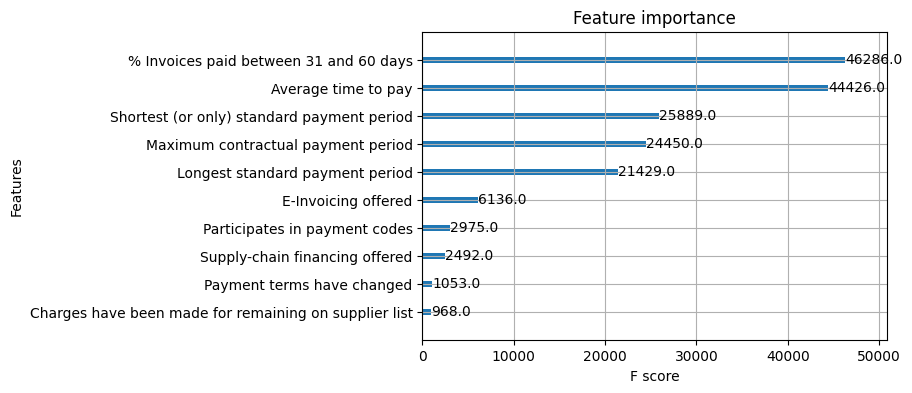

In [354]:
xgb.plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

Random Forest

In [355]:
# RandomForestClassifier
rf_clf = RandomForestClassifier( max_depth=10, n_estimators=900 ,random_state=42)

# Fit the model to the data
rf_clf.fit(X_train_oversampled, y_train_oversampled)

# Make predictions on the data
y_pred_rf = rf_clf.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

f1_rf = f1_score(y_test, y_pred_rf)
print('F1 Score:', f1_rf)

# Calculate AUC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
print('AUC:', auc_rf)

Random Forest Accuracy: 0.7238007943782463
F1 Score: 0.5046575342465753
AUC: 0.7299059281835889


Gradient Boost Descision Tree

In [356]:
from sklearn.ensemble import GradientBoostingClassifier

# Create an instance of the GradientBoostingClassifier
gbdt_clf = GradientBoostingClassifier(n_estimators=900, learning_rate=0.01, max_depth=10, random_state=42)

# Fit the model to the data
gbdt_clf.fit(X_train_oversampled, y_train_oversampled)

# Make predictions on the test data
y_pred_gbdt = gbdt_clf.predict(X_test)

# Calculate accuracy
accuracy_gbdt = accuracy_score(y_test, y_pred_gbdt)
print("Gradient Boosting Decision Tree Accuracy:", accuracy_gbdt)

# Calculate F1 score
f1_gbdt = f1_score(y_test, y_pred_gbdt)
print("F1 Score:", f1_gbdt)

# Calculate AUC
fpr_gbdt, tpr_gbdt, _ = roc_curve(y_test, y_pred_gbdt)
auc_gbdt = auc(fpr_gbdt, tpr_gbdt)
print("AUC:", auc_gbdt)


Gradient Boosting Decision Tree Accuracy: 0.7888787045523984
F1 Score: 0.523448275862069
AUC: 0.7203069209492184


LightGBM

In [357]:
import lightgbm as lgb

# Create a LightGBM dataset for training
train_data = lgb.Dataset(X_train_oversampled, label=y_train_oversampled)

# Train the model
lgb_clf = lgb.train(params, train_data, num_boost_round=20)

#y_pred_lgb = lgb_clf.predict(X_test)
y_pred_lgb = (lgb_clf.predict(X_test) > 0.5).astype(int)

# Calculate accuracy
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("LightGBM Accuracy:", accuracy_lgb)

# Calculate F1 score
f1_lgb = f1_score(y_test, y_pred_lgb)
print("F1 Score:", f1_lgb)

# Calculate AUC
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_lgb)
auc_lgb = auc(fpr_lgb, tpr_lgb)
print("AUC:", auc_lgb)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 564
[LightGBM] [Info] Number of data points in the train set: 24538, number of used features: 10
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.7270088603727467
F1 Score: 0.5034731869963879
AUC: 0.7272774175365867


XGBoost + Linear Regression

In [358]:
# Train linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_oversampled, y_train_oversampled)

# Get residuals from linear regression predictions
residuals = y_train_oversampled - linear_model.predict(X_train_oversampled)

# Train XGBoost model on residuals
xgb_model = XGBRegressor(**params)
xgb_model.fit(X_train_oversampled, y_train_oversampled)

# Function to make predictions with the hybrid model
def hybrid_predict(data_point):
  linear_pred = linear_model.predict([data_point])[0]
  residual_pred = xgb_model.predict([data_point])[0]
  return linear_pred + residual_pred


y_pred_xgblr = [hybrid_predict(i) for i in X_test.values]

# Convert predictions to binary values
y_pred_xgblr = [1 if pred > 0.5 else 0 for pred in y_pred_xgblr]

# Calculate accuracy
accuracy_xgblr = accuracy_score(y_test, y_pred_xgblr)
print("XGB+LR Accuracy:", accuracy_xgblr)

# Calculate F1 score
f1_xgblr = f1_score(y_test, y_pred_xgblr)
print("F1 Score:", f1_xgblr)

# Calculate AUC
fpr_xgblr, tpr_xgblr, _ = roc_curve(y_test, y_pred_xgblr)
auc_xgblr = auc(fpr_xgblr, tpr_xgblr)
print("AUC:", auc_xgblr)

XGB+LR Accuracy: 0.4805988389856401
F1 Score: 0.40787182166492514
AUC: 0.6565667309873335


Random Forest + Linear Regression

In [359]:
# Train linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_oversampled, y_train_oversampled)

# Get residuals from linear regression predictions
residuals = y_train_oversampled - linear_model.predict(X_train_oversampled)

# Train Random Forest model on residuals
rf_model = RandomForestRegressor( max_depth=10, n_estimators=900 ,random_state=42)
rf_model.fit(X_train_oversampled, y_train_oversampled)

# Function to make predictions with the hybrid model
def hybrid_predict(data_point):
  linear_pred = linear_model.predict([data_point])[0]
  residual_pred = rf_model.predict([data_point])[0]
  return linear_pred + residual_pred


y_pred_rflr = [hybrid_predict(i) for i in X_test.values]

# Convert predictions to binary values
y_pred_rflr = [1 if pred > 0.5 else 0 for pred in y_pred_rflr]

# Calculate accuracy
accuracy_rflr = accuracy_score(y_test, y_pred_rflr)
print("RF+LR Accuracy:", accuracy_rflr)

# Calculate F1 score
f1_rflr = f1_score(y_test, y_pred_rflr)
print("F1 Score:", f1_rflr)

# Calculate AUC\
fpr_rflr, tpr_rflr, _ = roc_curve(y_test, y_pred_rflr)
auc_rflr = auc(fpr_rflr, tpr_rflr)
print("AUC:", auc_rflr)

RF+LR Accuracy: 0.4199511151848457
F1 Score: 0.3853003075926825
AUC: 0.624959373430337


GBDT + Linear Regression 

In [360]:
# Train linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_oversampled, y_train_oversampled)

# Get residuals from linear regression predictions
residuals = y_train_oversampled - linear_model.predict(X_train_oversampled)

# Train Random Forest model on residuals
gbdt_clf1 = GradientBoostingClassifier(n_estimators=900, learning_rate=0.01, max_depth=10, random_state=42)
gbdt_clf1.fit(X_train_oversampled, y_train_oversampled)

# Function to make predictions with the hybrid model
def hybrid_predict(data_point):
  linear_pred = linear_model.predict([data_point])[0]
  residual_pred = gbdt_clf1.predict([data_point])[0]
  return linear_pred + residual_pred


y_pred_gbdtlr = [hybrid_predict(i) for i in X_test.values]

# Convert predictions to binary values
y_pred_gbdtlr = [1 if pred > 0.5 else 0 for pred in y_pred_gbdtlr]

# Calculate accuracy
accuracy_gbdtlr = accuracy_score(y_test, y_pred_gbdtlr)
print("GBDT+LR Accuracy:", accuracy_gbdtlr)

# Calculate F1 score
f1_gbdtlr = f1_score(y_test, y_pred_gbdtlr)
print("F1 Score:", f1_gbdtlr)

# Calculate AUC
fpr_gbdtlr, tpr_gbdtlr, _ = roc_curve(y_test, y_pred_gbdtlr)
auc_gbdtlr = auc(fpr_gbdtlr, tpr_gbdtlr)
print("AUC:", auc_gbdtlr)

GBDT+LR Accuracy: 0.6413076688053774
F1 Score: 0.45496750232126276
AUC: 0.6971019334837936


Comparing the models

In [361]:
# Comparing the models

results = {
    'Model': ['XGBoost', 'Random Forest', 'GBDT', 'LightGBM', 'XGB+LR', 'RF+LR', 'GBDT+LR'],
    'Accuracy': [accuracy_xgb, accuracy_rf, accuracy_gbdt, accuracy_lgb, accuracy_xgblr, accuracy_rflr, accuracy_rflr],
    'F1 Score': [f1_xgb, f1_rf, f1_gbdt, f1_lgb, f1_xgblr, f1_rflr, f1_rflr],
    'AUC': [auc_xgb, auc_rf, auc_gbdt, auc_lgb, auc_xgblr, auc_rflr, auc_rflr]
}

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,F1 Score,AUC
0,XGBoost,0.777880,0.529450,0.731646
1,Random Forest,0.723801,0.504658,0.729906
2,GBDT,0.788879,0.523448,0.720307
3,LightGBM,0.727009,0.503473,0.727277
4,XGB+LR,0.480599,0.407872,0.656567
5,RF+LR,0.419951,0.385300,0.624959
6,GBDT+LR,0.419951,0.385300,0.624959


Receiver Operating Characteristic (ROC) Curves

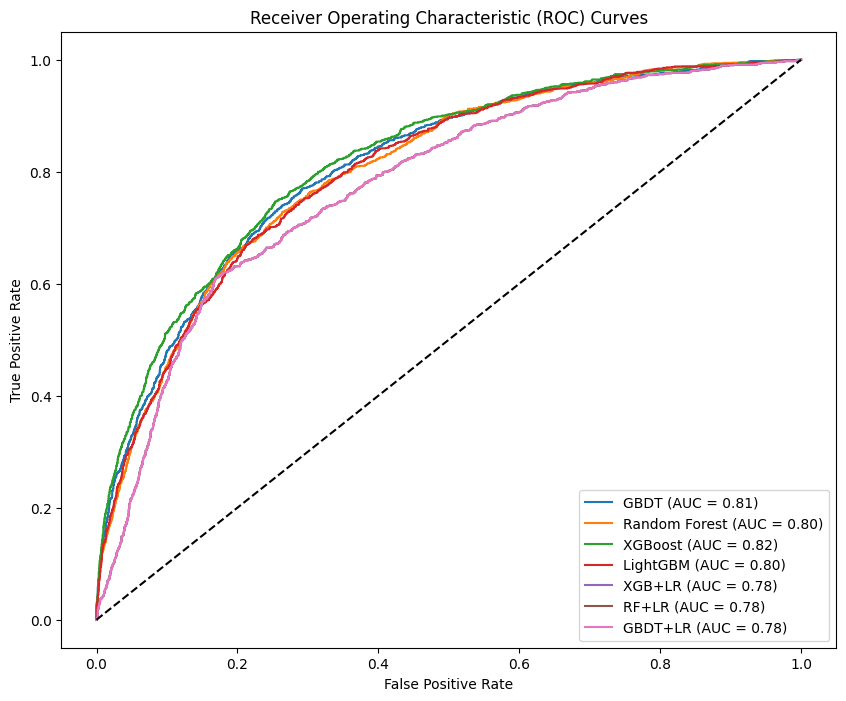

In [362]:
# Define the true labels
y_true = y_test

# Define the predicted probabilities for each model
y_pred_gbdt = gbdt_clf.predict_proba(X_test)[:, 1]
y_pred_rf = rf_clf.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_lgb = lgb_clf.predict(X_test)
y_pred_xgblr = [hybrid_predict(i) for i in X_test.values]
y_pred_rflr = [hybrid_predict(i) for i in X_test.values]
y_pred_gbdtlr = [hybrid_predict(i) for i in X_test.values]

# Calculate the false positive rate and true positive rate for each model
fpr_gbdt, tpr_gbdt, _ = roc_curve(y_true, y_pred_gbdt)
fpr_rf, tpr_rf, _ = roc_curve(y_true, y_pred_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_true, y_pred_xgb)
fpr_lgb, tpr_lgb, _ = roc_curve(y_true, y_pred_lgb)
fpr_xgblr, tpr_xgblr, _ = roc_curve(y_true, y_pred_xgblr)
fpr_rflr, tpr_rflr, _ = roc_curve(y_true, y_pred_rflr)
fpr_gbdtlr, tpr_gbdtlr, _ = roc_curve(y_true, y_pred_gbdtlr)

# Calculate the AUC for each model
auc_gbdt = auc(fpr_gbdt, tpr_gbdt)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_lgb = auc(fpr_lgb, tpr_lgb)
auc_xgblr = auc(fpr_xgblr, tpr_xgblr)
auc_rflr = auc(fpr_rflr, tpr_rflr)
auc_gbdtlr = auc(fpr_gbdtlr, tpr_gbdtlr)

# Plot the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_gbdt, tpr_gbdt, label=f'GBDT (AUC = {auc_gbdt:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {auc_lgb:.2f})')
plt.plot(fpr_xgblr, tpr_xgblr, label=f'XGB+LR (AUC = {auc_xgblr:.2f})')
plt.plot(fpr_rflr, tpr_rflr, label=f'RF+LR (AUC = {auc_rflr:.2f})')
plt.plot(fpr_gbdtlr, tpr_gbdtlr, label=f'GBDT+LR (AUC = {auc_gbdtlr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()
